In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import loaders
import hyperparameters
import training
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
## setup current model and load weights
resnet50 = models.resnet50()
num_classes = 7
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
pretrained = torch.load("./saved_model/resnet50_on_FER.pth")
resnet50.load_state_dict(pretrained["state_dict"])
resnet50.to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
## make some evaluation on full image (no mask)
full_val_loader = loaders.get_loader(
    mask="full", train=False, shuffle=True
)

In [5]:
loss_func = nn.CrossEntropyLoss().to(device)

In [6]:
with torch.no_grad():
    val_loss = 0
    total_examples = 0
    correct_examples = 0
    for batch_idx, (inputs, targets) in enumerate(full_val_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # count the number of correctly predicted samples
        # in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        val_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
avg_loss = val_loss / len(full_val_loader)
val2_avg_acc = correct_examples / total_examples
print(
    "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, val2_avg_acc)
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.9510, Validation accuracy: 0.6649


In [7]:
## make some evaluation on left masked image (left mask)
left_mask_val_loader = loaders.get_loader(
    mask="left", train=False, shuffle=True
)
with torch.no_grad():
    val_loss = 0
    total_examples = 0
    correct_examples = 0
    for batch_idx, (inputs, targets) in enumerate(left_mask_val_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # count the number of correctly predicted samples
        # in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        val_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
avg_loss = val_loss / len(left_mask_val_loader)
val1_avg_acc = correct_examples / total_examples
print(
    "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, val1_avg_acc)
)

Validation loss: 1.6010, Validation accuracy: 0.4200


In [8]:
## trainning data
left_mask_train_loader = loaders.get_loader(
    mask="left", train=True, shuffle=True
)

In [9]:
(tr_acc, _, val1_acc, _, val2_acc, _) = training.train_model(
    resnet50,
    device,
    hyperparameters.CHECKPOINT_FOLDER,
    "left.pth",
    hyperparameters.LR,
    hyperparameters.MOMENTUM,
    # hyperparameters.REG,
    5e-4,
    15,
    left_mask_train_loader,
    left_mask_val_loader,
    loss_func,
    full_val_loader,
    0.1,
    5
)

==> Training starts!
Epoch 0:
Training loss: 1.2571, Training accuracy: 0.5200
Validation loss: 1.2119, Validation accuracy: 0.5433
Saving ...

Validation loss: 1.0870, Validation accuracy: 0.5893
Epoch 1:
Training loss: 1.0917, Training accuracy: 0.5894
Validation loss: 1.1810, Validation accuracy: 0.5513
Saving ...

Validation loss: 1.0973, Validation accuracy: 0.5855
Epoch 2:
Training loss: 1.0137, Training accuracy: 0.6152
Validation loss: 1.2110, Validation accuracy: 0.5401

Validation loss: 1.1095, Validation accuracy: 0.5834
Epoch 3:
Training loss: 0.9507, Training accuracy: 0.6443
Validation loss: 1.1588, Validation accuracy: 0.5750
Saving ...

Validation loss: 1.0913, Validation accuracy: 0.6023
Epoch 4:
Training loss: 0.9015, Training accuracy: 0.6628
Validation loss: 1.1808, Validation accuracy: 0.5656

Validation loss: 1.1265, Validation accuracy: 0.5932
Epoch 5:
Training loss: 0.8580, Training accuracy: 0.6834
Validation loss: 1.1787, Validation accuracy: 0.5768
Saving ...

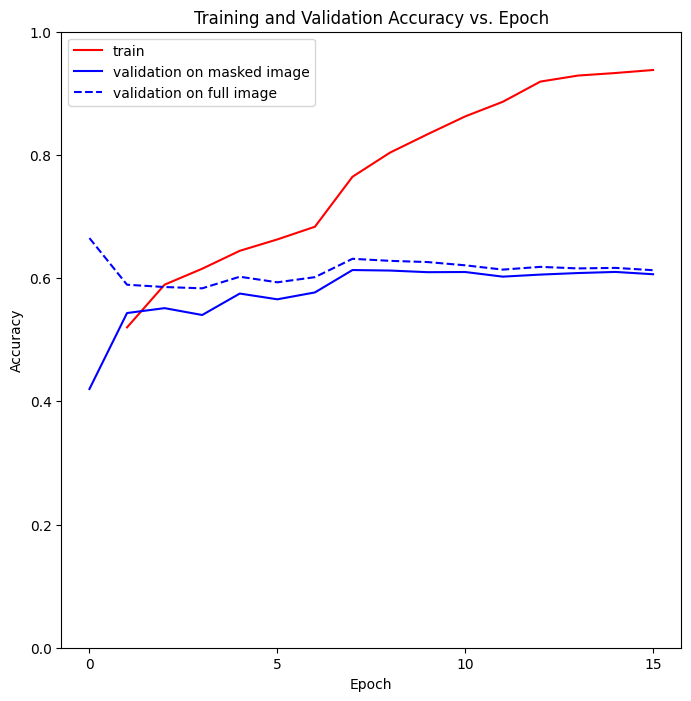

In [10]:
## make plots
val1_plot = [val1_avg_acc] ## on masked
val2_plot = [val2_avg_acc] ## on full
train_plot = tr_acc[:]
val1_plot.extend(val1_acc[:])
val2_plot.extend(val2_acc[:])
plt.figure(figsize=(8,8))
plt.plot(range(1, len(train_plot) + 1), train_plot, 'r', label="train")
plt.plot(range(len(val1_plot)), val1_plot, "b", label="validation on masked image")
plt.plot(range(len(val2_plot)), val2_plot, "b--", label="validation on full image")
plt.xticks(np.arange(0, max(len(train_plot) + 1, len(val1_plot), len(val2_plot)), 5.0))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs. Epoch")
plt.ylim(0,1)
plt.show()